# Distance cutoff policy

[Index](../0-index.ipynb)

Here we investigate how truncating interactions to nearest neighbors (based on a distance cutoff) affect the spreading of the epidemic.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import os,sys
import numpy as np
import pandas as pd
import h5py
import datetime
import networkx as ntx

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.cm as cm
from matplotlib import animation
plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import HTML
from IPython.display import Image

In [3]:
sys.path.append(str(Path('../..') / 'code'))

In [4]:
resdir = Path('../../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [5]:
resfile = resdir / 'safegraph_analysis.hdf5'
complevel=7
complib='zlib'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    print(f"File {resfile.stem} has {len(store.keys())} entries.")

File safegraph_analysis has 838 entries.


## Global variables and other quantities

### Global variables

In [6]:
gamma = 1/10.
ti = '2020-03-01'
tf = '2021-02-16'

tfmt = '%Y-%m-%d'
ti = datetime.datetime.strptime(ti, tfmt)
tf = datetime.datetime.strptime(tf, tfmt)

pathtofit = Path('/fit')
pathtosimu = Path('/simulations/distance_cutoff')

exts = ['.png', '.svg']

### Load clusters to get population

In [7]:
key = "/clustering/clusters"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    clusters = store[key]
# clusters = pd.read_hdf(resfile, key)
N = len(clusters)
print(f"N = {N}")
clusters

N = 1024


,leaves,X,Y,cbg_clusters,population,mobile_count
index,,,,,,
0,746,-65.794825,18.277415,"[720531504003, 720531501044, 720531505001, 720...",390728,8705.198547
1,458,-66.083320,18.131576,"[720572702011, 720572703004, 720572705001, 720...",488287,10942.351090
2,873,-66.079340,18.396328,"[720210307001, 720210310113, 720210316223, 720...",1011530,28389.915254
3,8,-66.344566,18.363775,"[720399559001, 720399556001, 720399557001, 720...",425126,9988.154964
4,641,-66.582628,18.044742,"[721130724005, 721130727011, 721130727012, 721...",354598,12057.116223
...,...,...,...,...,...,...
1019,911,-158.026269,21.423245,"[150030078092, 150030078102, 150030099044, 150...",459209,22780.496368
1020,7,-157.813184,21.329035,"[150090318011, 150099900000, 150030047001, 150...",529047,21868.060533
1021,392,-156.517054,20.867763,"[150090311032, 150090304042, 150090309034, 150...",161290,7878.004843


In [8]:
population = clusters['population'].to_numpy()
population_inv = np.zeros(population.shape, dtype=np.float_)
idx = population > 0.
population_inv[idx] = 1./population[idx]

### Load matrix of distances

In [9]:
key = "/clustering/distances"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    distances = store[key].to_numpy()

### Read fit

In [10]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    mykey = str(pathtofit / 'result' / 'fit')
    df_fit = store[mykey]

times = df_fit.index
idx = (times >= ti) & (times <= tf)
df_fit.drop(index=times[~idx], inplace=True)
times = df_fit.index.to_pydatetime().tolist()
df_fit

,scale,frac_infected_tot,scale_sigmoid,scale_step
2020-03-01,0.34322,0.0,0.251068,0.253942
2020-03-02,0.207449,0.0,0.250534,0.253942
2020-03-03,0.253454,0.0,0.249903,0.253942
2020-03-04,0.374544,0.0,0.249158,0.253942
2020-03-05,0.177103,0.000001,0.24828,0.253942
...,...,...,...,...
2021-02-12,0.040918,0.083887,0.055336,0.055336
2021-02-13,0.03206,0.084156,0.055336,0.055336
2021-02-14,0.027507,0.08436,0.055336,0.055336
2021-02-15,0.033736,0.084526,0.055336,0.055336


### Determine lockdown time

In [11]:
b_scales = df_fit['scale_step'].fillna(value=np.nan).to_numpy()
ic = np.nanargmax(np.abs(np.diff(b_scales))) + 1
tc = df_fit.index[ic]
print(f"lockdown at t = {tc}")

lockdown at t = 2020-03-25 00:00:00


In [12]:
df_fit.iloc[ic-1:ic+2]

,scale,frac_infected_tot,scale_sigmoid,scale_step
2020-03-24,0.140192,0.000172,0.166496,0.253942
2020-03-25,0.162633,0.000208,0.157958,0.055336
2020-03-26,0.150148,0.000259,0.14937,0.055336


In [13]:
smax = np.nanmax(b_scales)
smin = np.nanmin(b_scales)
scale = smin + 1*(smax-smin)
print("scale = {:.4f}    smin = {:.4f}    smax = {:.4f}".format(scale, smin, smax))

scale = 0.2539    smin = 0.0553    smax = 0.2539


## Perform simulation

In [14]:
#### from functions import sir_SI_to_X
from functions import integrate_sir, get_sir_omega_SI
from scipy.special import xlogy

### Parameters

In [15]:
dc_list = 2**np.arange(5, dtype=np.float_)*100  # distance cutoffs (km)
dcfmt = "dc_{:.0f}km"  # format for dc directories

### Define initial condition

In [16]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    mykey = str(pathtofit / 'result' / 'susceptible')
    df_S_fit = store[mykey]
    
    mykey = str(pathtofit / 'result' / 'infected')
    df_I_fit = store[mykey]

In [17]:
Si = df_S_fit.iloc[0].to_numpy()
Ii = df_I_fit.iloc[0].to_numpy()
imax = np.argmax(Ii)
vmax = Ii[imax]
Ii = np.zeros(Ii.shape, dtype=Ii.dtype)
Ii[imax]=vmax
# Xi = sir_SI_to_X(Si, Ii)

In [18]:
T_fit = 1. - df_S_fit.to_numpy().astype('float64')
dT_fit = np.diff(T_fit, axis=0)
dT_fit = np.concatenate([T_fit[0].reshape(1,-1), dT_fit], axis=0)

df_T_fit = pd.DataFrame(data=T_fit, index=df_S_fit.index, columns=df_S_fit.columns)
df_dT_fit = pd.DataFrame(data=dT_fit, index=df_S_fit.index, columns=df_S_fit.columns)

In [19]:
T_tot_fit = np.einsum('ta,a', T_fit, population) / np.sum(population)
dT_tot_fit = np.einsum('ta,a', dT_fit, population) / np.sum(population)

### Construct the localization matrices

In [20]:
from functions import sir_SI_to_X

In [21]:
print("Path to simulations: {:s}".format(str(pathtosimu)))

Path to simulations: /simulations/distance_cutoff


In [22]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    key = pathtofit / 'infectivity_matrices' / times[0].strftime(tfmt)
    key = str(key)
    df_loc = store[key]

In [23]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    if pathtosimu in store.keys():
        for rt, dirs, files in store.walk(str(pathtosimu)):
            for f in files:
                fpath = Path(rt) / f
                print(str(fpath))
                del store[str(fpath)]

In [24]:
for k in range(len(dc_list)):
    dc = dc_list[k]
    print("dc = {:.0f}km".format(dc))
    dcpath = pathtosimu / dcfmt.format(dc)
    
    # compute selection matrix
    phi = np.int_(distances < dc*1.0e3)
    
    # localization matrix
    pathtoloc = dcpath / 'infectivity_matrices'
    print(pathtoloc)
    
    with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
        pref = times[0].strftime(tfmt)

        # set to zero entries corresponding to a distance > cutoff
        key = pathtoloc / pref
        key = str(key)
        store[key] = phi*df_loc
        
    # initial condition
    pathtoinit = dcpath / 'initial_condition'
    print(pathtoinit)
    
    ## compute connected components
    G = ntx.convert_matrix.from_numpy_matrix(phi)
    con_comp = sorted(ntx.connected_components(G), key=len, reverse=True)
    
    ## get closest (in terms of indices) cluster belonging to the largest connected component
    c = np.array(list(con_comp[0]))
    k0 = np.argmin(distances[imax,c])
    i0 = c[k0]
    print("Initial cluster in community {:d}".format(i0))
    
    ## save initial condition
    S = Si.copy()
    I = np.zeros(Ii.shape, dtype=Ii.dtype)
    S = np.ones(Si.shape, dtype=Ii.dtype)
    I[i0] = Ii[imax]
    S[i0] = 1.-Ii[imax]
    X = sir_SI_to_X(S, I)
    with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
        store[str(pathtoinit)] = pd.DataFrame(data=X.reshape(1,-1), index=times[:1])

dc = 100km
/simulations/distance_cutoff/dc_100km/infectivity_matrices
/simulations/distance_cutoff/dc_100km/initial_condition
Initial cluster in community 561
dc = 200km
/simulations/distance_cutoff/dc_200km/infectivity_matrices
/simulations/distance_cutoff/dc_200km/initial_condition
Initial cluster in community 856
dc = 400km
/simulations/distance_cutoff/dc_400km/infectivity_matrices
/simulations/distance_cutoff/dc_400km/initial_condition
Initial cluster in community 856
dc = 800km
/simulations/distance_cutoff/dc_800km/infectivity_matrices
/simulations/distance_cutoff/dc_800km/initial_condition
Initial cluster in community 856
dc = 1600km
/simulations/distance_cutoff/dc_1600km/infectivity_matrices
/simulations/distance_cutoff/dc_1600km/initial_condition
Initial cluster in community 856


### Simulation

In [25]:
for k in range(len(dc_list)):
    dc = dc_list[k]
    print("dc = {:.0f}km".format(dc))
    dcpath = pathtosimu / dcfmt.format(dc)
    pathtoloc = dcpath / 'infectivity_matrices'
    print(pathtoloc)
    
    pathtoinit = dcpath / 'initial_condition'

    with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
        Xi = np.ravel(store[str(pathtoinit)].to_numpy())
        ts, Ss, Is  = integrate_sir(Xi, [times[0], times[-1]], [scale], gamma, store, pathtoloc)

    df_S = pd.DataFrame(data=Ss, index=ts, columns=np.arange(N))
    df_I = pd.DataFrame(data=Is, index=ts, columns=np.arange(N))

    path = dcpath / 'result'
    with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
        key = path / 'susceptible'
        store[str(key)] = df_S

        key = path / 'infected'
        store[str(key)] = df_I

dc = 100km
/simulations/distance_cutoff/dc_100km/infectivity_matrices
Integrating day 2020-03-01 00:00:00
Integration complete
dc = 200km
/simulations/distance_cutoff/dc_200km/infectivity_matrices
Integrating day 2020-03-01 00:00:00
Integration complete
dc = 400km
/simulations/distance_cutoff/dc_400km/infectivity_matrices
Integrating day 2020-03-01 00:00:00
Integration complete
dc = 800km
/simulations/distance_cutoff/dc_800km/infectivity_matrices
Integrating day 2020-03-01 00:00:00
Integration complete
dc = 1600km
/simulations/distance_cutoff/dc_1600km/infectivity_matrices
Integrating day 2020-03-01 00:00:00
Integration complete


## Visualize the global epidemic size

In [26]:
for k in range(len(dc_list)):
    dc = dc_list[k]
    print("dc = {:.0f}km".format(dc))
    dcpath = pathtosimu / dcfmt.format(dc)
    pathtoloc = dcpath / 'infectivity_matrices'
    print(pathtoloc)

    path = dcpath / 'result'
    with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
        key = path / 'susceptible'
        df_S = store[str(key)]
    break
ts = df_S.index

dc = 100km
/simulations/distance_cutoff/dc_100km/infectivity_matrices


In [27]:
T_tots = []
dT_tots = []
for k in range(len(dc_list)):
    dc = dc_list[k]
    print("dc = {:.0f}km".format(dc))
    dcpath = pathtosimu / dcfmt.format(dc)

    path = dcpath / 'result'
    with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
        key = path / 'susceptible'
        df_S = store[str(key)]
        key = path / 'infected'
        df_I = store[str(key)]
        df_T = 1. - df_S
        T = df_T.to_numpy().astype('float64')
        dT = np.diff(T, axis=0)
        dT = np.concatenate([T[0].reshape(1,-1), dT], axis=0)

        T_tot = np.einsum('ta,a->t', T, population) / np.sum(population)
        dT_tot = np.einsum('ta,a->t', dT, population) / np.sum(population)
    T_tots.append(T_tot)
    dT_tots.append(dT_tot)
    
T_tots = np.array(T_tots)
dT_tots = np.array(dT_tots)

dc = 100km
dc = 200km
dc = 400km
dc = 800km
dc = 1600km


In [28]:
figdir = Path('..') / '..' / 'figures' / '6-simulations' / '62-distance_cutoff'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)

In [29]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=2
lw=1
show_dT=True
Z = np.sum(population) / 1000000

ndc = len(dc_list)
norm = mco.Normalize(vmin=0, vmax=ndc-1)
cmap = cm.rainbow

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

if show_dT:
    for n in range(ndc):
        color = cmap(norm(n))
        label = "dc = {:.0f} km".format(dc_list[n])
        ax.plot(ts, dT_tots[n]*Z, ls='-', lw=lw, color=color, label=label)
    ax.set_ylabel("$d T$", fontsize="medium")
    fname = 'domega_tot_fit'
else:
    for n in range(ndc):
        color = cmap(norm(n))
        label = "dc = {:.0f} km".format(dc_list[n])
        ax.plot(ts, T_tots[n]*Z, ls='-', lw=lw, color=color, label=label)
    ax.set_ylabel("$T$", fontsize="medium")
    ax.set_yscale('log')
    fname = 'omega_tot_fit'

ax.set_xlim(times[0],None)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../../figures/6-simulations/62-distance_cutoff/domega_tot_fit.png
Written file: ../../figures/6-simulations/62-distance_cutoff/domega_tot_fit.svg


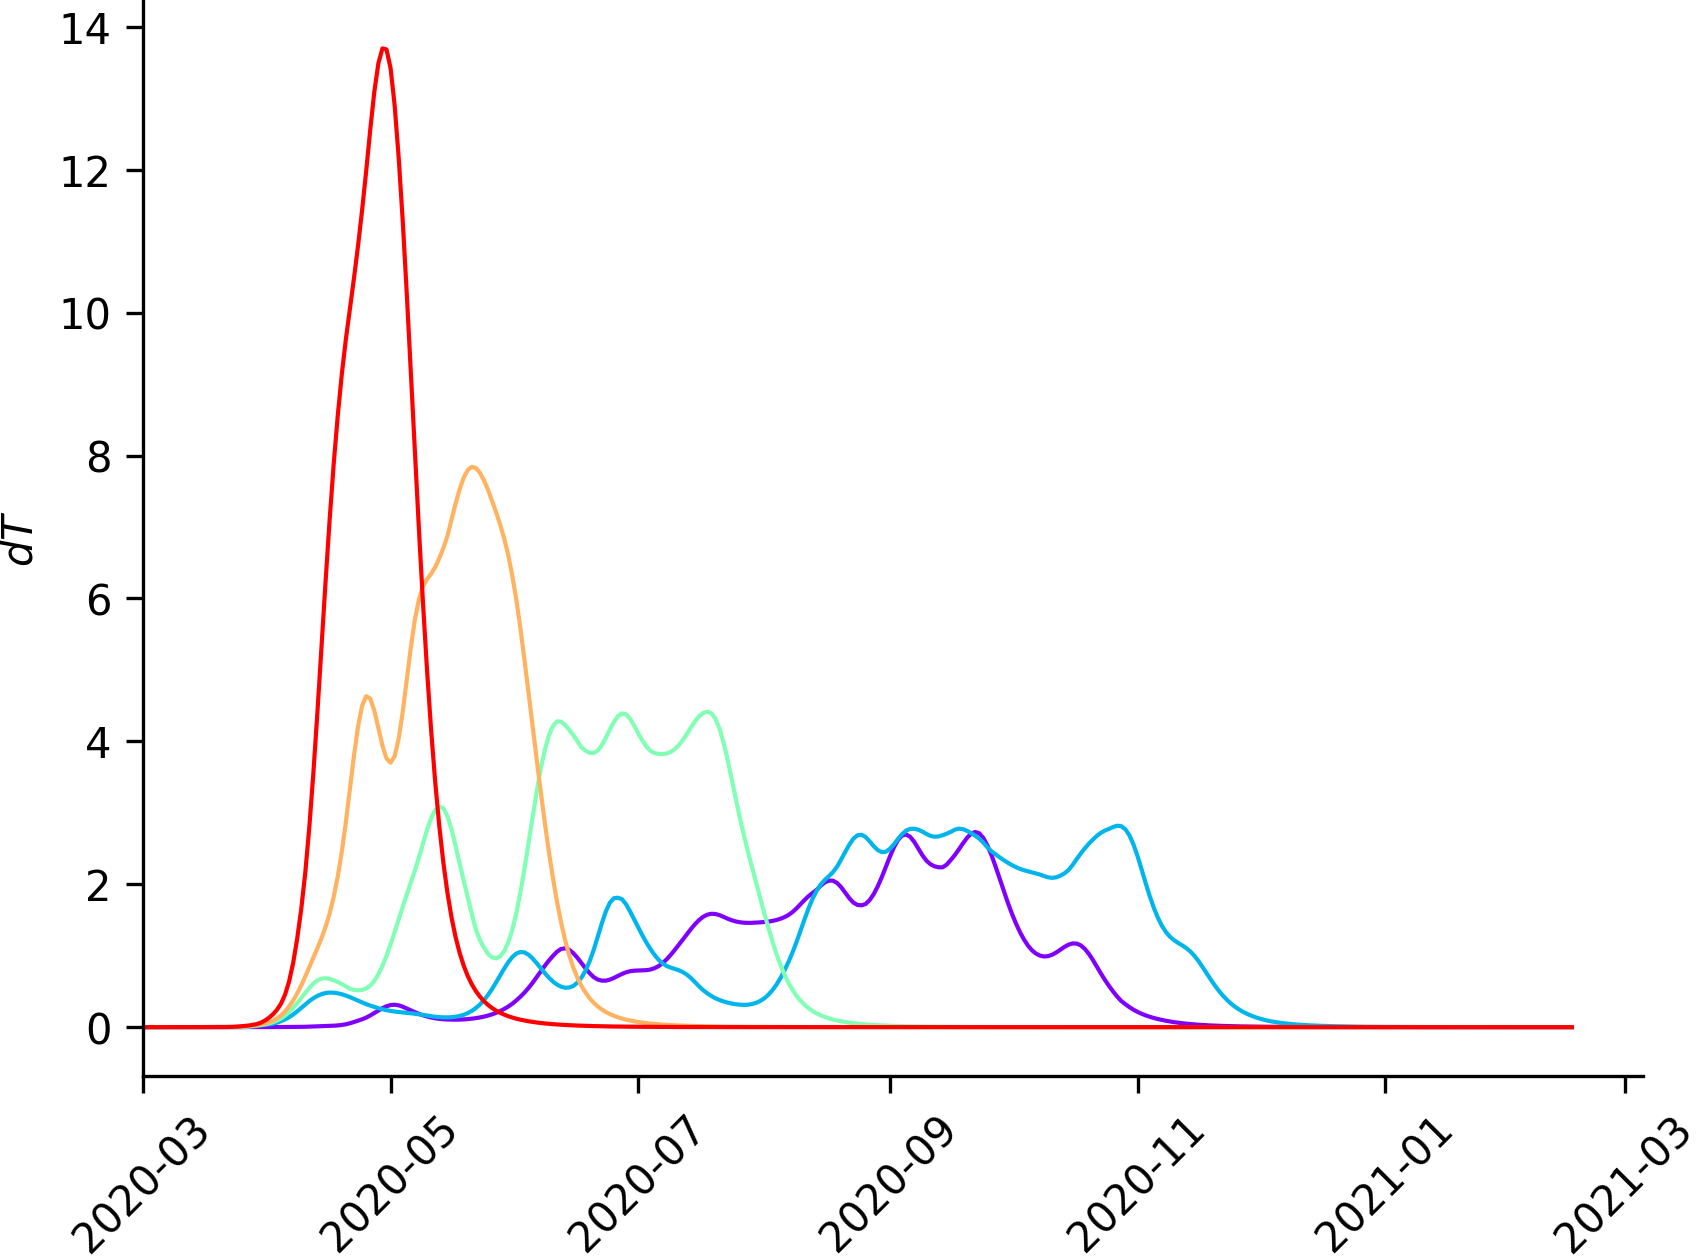

In [30]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Show time-dependent profile

In [31]:
from functions import plot_omega_profile

In [32]:
for k in range(len(dc_list)):
    dc = dc_list[k]
    print("dc = {:.0f}km".format(dc))
    dcpath = pathtosimu / dcfmt.format(dc)
    pathtoloc = dcpath / 'infectivity_matrices'
    print(pathtoloc)

    path = dcpath / 'result'
    with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
        key = path / 'susceptible'
        df_S = store[str(key)]
    break
ts = df_S.index

dc = 100km
/simulations/distance_cutoff/dc_100km/infectivity_matrices


In [33]:
Ts = []
dTs = []
for k in range(len(dc_list)):
    dc = dc_list[k]
    print("dc = {:.0f}km".format(dc))
    dcpath = pathtosimu / dcfmt.format(dc)
    pathtoloc = dcpath / 'infectivity_matrices'
    print(pathtoloc)

    path = dcpath / 'result'
    with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
        key = path / 'susceptible'
        df_S = store[str(key)]
        df_T = 1. - df_S
        T = df_T.to_numpy().astype('float64')
        dT = np.diff(T, axis=0)
        dT = np.concatenate([T[0].reshape(1,-1), dT], axis=0)
        Ts.append(T)
        dTs.append(dT)
        
Ts = np.array(Ts)
dTs = np.array(dTs)

dc = 100km
/simulations/distance_cutoff/dc_100km/infectivity_matrices
dc = 200km
/simulations/distance_cutoff/dc_200km/infectivity_matrices
dc = 400km
/simulations/distance_cutoff/dc_400km/infectivity_matrices
dc = 800km
/simulations/distance_cutoff/dc_800km/infectivity_matrices
dc = 1600km
/simulations/distance_cutoff/dc_1600km/infectivity_matrices


In [34]:
# parameters
dpi=150
fps=10
figsize=(6, 4.5)
lw=0.5
ms=4

mydir = figdir / 'profiles'
if not mydir.is_dir():
    mydir.mkdir(parents=True, exist_ok=True)

ndc = dTs.shape[0]
nt = dTs.shape[1]

norm = mco.Normalize(vmin=0, vmax=ndc-1)
cmap = cm.rainbow
colors = [cmap(norm(n)) for n in range(ndc)]
labels = ["dc = {:.0f} km".format(dc) for dc in dc_list]
styles = ['-']*ndc

fpath = mydir / 'profile_T.mp4'
ylabel="$T_a$"
plot_omega_profile(np.einsum('nta,a->nta', Ts, population), ts, labels=labels, colors=colors, \
                   fileout=fpath, tpdir=mydir / 'snapshots_T', dpi=dpi, fps=fps, figsize=figsize, ylabel=ylabel, \
                   lw=lw, ms=ms, styles=styles, deletetp=False, exts=['.png','.svg'], ymin=1.)

fpath = mydir / 'profile_dT.mp4'
ylabel="$dT_a$"
plot_omega_profile(np.einsum('nta,a->nta', dTs, population), ts, labels=labels, colors=colors, \
                   fileout=fpath, tpdir=mydir / 'snapshots_dT', dpi=dpi, fps=fps, figsize=figsize, ylabel=ylabel, \
                   lw=lw, ms=ms, styles=styles, deletetp=False, exts=['.png','.svg'], ymin=1.)


ymin = 1.00e+00 ymax = 1.00e+07
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_T/2020-03-01.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_T/2020-03-11.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_T/2020-03-21.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_T/2020-03-31.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_T/2020-04-10.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_T/2020-04-20.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_T/2020-04-30.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_T/2020-05-10.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_T/2020-05-20.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_T/2020-05-30.png

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (795, 605) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/62-distance_cutoff/profiles/profile_T.mp4.
ymin = 1.00e+00 ymax = 1.00e+06
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_dT/2020-03-01.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_dT/2020-03-11.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_dT/2020-03-21.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_dT/2020-03-31.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_dT/2020-04-10.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_dT/2020-04-20.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_dT/2020-04-30.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_dT/2020-05-10.png.
Written file ../../figures/6-simulations/62-distance_cutoff/profiles/snapshots_dT/2020-05-20.png.
Wr

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (796, 605) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/62-distance_cutoff/profiles/profile_dT.mp4.


In [35]:
fpath = figdir / 'profiles' / 'profile_T.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))

In [36]:
fpath = figdir / 'profiles' / 'profile_dT.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))

## Show time-dependent map

In [37]:
from functions import plot_omega_map

In [38]:
# parameters
dpi=150
fps=10
figsize=(6, 4.5)
lw=0.5
ms=4
idump=1
vmin=1.

mydir = figdir / 'maps'
if not mydir.is_dir():
    mydir.mkdir(parents=True, exist_ok=True)

ndc = Ts.shape[0]
nt = Ts.shape[1]

norm = mco.Normalize(vmin=0, vmax=ndc-1)
cmap = cm.rainbow
colors = [cmap(norm(n)) for n in range(ndc)]
labels = ["dc = {:.0f} km".format(dc) for dc in dc_list]

for k in range(ndc):
    dc = dc_list[k]
    
    fpath = mydir / 'map_T_dc{:.0f}km.mp4'.format(dc)
    plot_omega_map(np.einsum('ta,a->ta', Ts[k], population), ts, XY=clusters.loc[:, ['X', 'Y']].to_numpy().T, \
    fileout=fpath, tpdir=mydir / 'snapshots_T_dc{:.0f}km'.format(dc), dpi=dpi, fps=fps, figsize=figsize, \
                   idump=idump, clabel="$T$", deletetp=False, exts=['.png', '.svg'], \
                  vmin=1., vmax=1.0e7)

    fpath = mydir / 'map_dT_dc{:.0f}km.mp4'.format(dc)
    plot_omega_map(np.einsum('ta,a->ta', dTs[k], population), ts, XY=clusters.loc[:, ['X', 'Y']].to_numpy().T, \
    fileout=fpath, tpdir=mydir / 'snapshots_dT_dc{:.0f}km'.format(dc), dpi=dpi, fps=fps, figsize=figsize, \
                   idump=idump, clabel="$dT$", deletetp=False, exts=['.png', '.svg'], \
                  vmin=1., vmax=1.0e6)
    print("Written {:s}".format(str(fpath)))

vmin = 1.00e+00 vmax = 1.00e+07
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc100km/2020-03-01.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc100km/2020-03-02.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc100km/2020-03-03.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc100km/2020-03-04.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc100km/2020-03-05.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc100km/2020-03-06.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc100km/2020-03-07.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc100km/2020-03-08.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc100km/2020-03-09.png.
Written file ../../figures/6-simulations/62-distance_cutoff

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/62-distance_cutoff/maps/map_T_dc100km.mp4.
vmin = 1.00e+00 vmax = 1.00e+06
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc100km/2020-03-01.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc100km/2020-03-02.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc100km/2020-03-03.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc100km/2020-03-04.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc100km/2020-03-05.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc100km/2020-03-06.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc100km/2020-03-07.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc100km/2020-03-08.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/sna

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/62-distance_cutoff/maps/map_dT_dc100km.mp4.
Written ../../figures/6-simulations/62-distance_cutoff/maps/map_dT_dc100km.mp4
vmin = 1.00e+00 vmax = 1.00e+07
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc200km/2020-03-01.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc200km/2020-03-02.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc200km/2020-03-03.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc200km/2020-03-04.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc200km/2020-03-05.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc200km/2020-03-06.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc200km/2020-03-07.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc200km/2020-03-08.p

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/62-distance_cutoff/maps/map_T_dc200km.mp4.
vmin = 1.00e+00 vmax = 1.00e+06
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc200km/2020-03-01.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc200km/2020-03-02.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc200km/2020-03-03.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc200km/2020-03-04.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc200km/2020-03-05.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc200km/2020-03-06.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc200km/2020-03-07.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc200km/2020-03-08.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/sna

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/62-distance_cutoff/maps/map_dT_dc200km.mp4.
Written ../../figures/6-simulations/62-distance_cutoff/maps/map_dT_dc200km.mp4
vmin = 1.00e+00 vmax = 1.00e+07
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc400km/2020-03-01.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc400km/2020-03-02.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc400km/2020-03-03.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc400km/2020-03-04.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc400km/2020-03-05.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc400km/2020-03-06.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc400km/2020-03-07.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc400km/2020-03-08.p

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/62-distance_cutoff/maps/map_T_dc400km.mp4.
vmin = 1.00e+00 vmax = 1.00e+06
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc400km/2020-03-01.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc400km/2020-03-02.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc400km/2020-03-03.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc400km/2020-03-04.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc400km/2020-03-05.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc400km/2020-03-06.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc400km/2020-03-07.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc400km/2020-03-08.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/sna

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/62-distance_cutoff/maps/map_dT_dc400km.mp4.
Written ../../figures/6-simulations/62-distance_cutoff/maps/map_dT_dc400km.mp4
vmin = 1.00e+00 vmax = 1.00e+07
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc800km/2020-03-01.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc800km/2020-03-02.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc800km/2020-03-03.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc800km/2020-03-04.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc800km/2020-03-05.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc800km/2020-03-06.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc800km/2020-03-07.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc800km/2020-03-08.p

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/62-distance_cutoff/maps/map_T_dc800km.mp4.
vmin = 1.00e+00 vmax = 1.00e+06
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc800km/2020-03-01.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc800km/2020-03-02.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc800km/2020-03-03.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc800km/2020-03-04.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc800km/2020-03-05.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc800km/2020-03-06.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc800km/2020-03-07.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc800km/2020-03-08.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/sna

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/62-distance_cutoff/maps/map_dT_dc800km.mp4.
Written ../../figures/6-simulations/62-distance_cutoff/maps/map_dT_dc800km.mp4
vmin = 1.00e+00 vmax = 1.00e+07
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc1600km/2020-03-01.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc1600km/2020-03-02.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc1600km/2020-03-03.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc1600km/2020-03-04.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc1600km/2020-03-05.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc1600km/2020-03-06.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc1600km/2020-03-07.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_T_dc1600km/2020

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/62-distance_cutoff/maps/map_T_dc1600km.mp4.
vmin = 1.00e+00 vmax = 1.00e+06
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc1600km/2020-03-01.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc1600km/2020-03-02.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc1600km/2020-03-03.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc1600km/2020-03-04.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc1600km/2020-03-05.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc1600km/2020-03-06.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc1600km/2020-03-07.png.
Written file ../../figures/6-simulations/62-distance_cutoff/maps/snapshots_dT_dc1600km/2020-03-08.png.
Written file ../../figures/6-simulations/62-distance_cutoff

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 497) to (880, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/62-distance_cutoff/maps/map_dT_dc1600km.mp4.
Written ../../figures/6-simulations/62-distance_cutoff/maps/map_dT_dc1600km.mp4


In [39]:
fpath = figdir / 'maps' / 'map_T_dc200km.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))